# In-class exercise 5b: classification
## Predicting firms' default

The objective is to build a classifier for whether a firm is going to default. 

In [1]:
import numpy as np
import pandas as pd
# import patsy

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 

import seaborn as sns
import matplotlib.pyplot as plt

### Question 1. Prepare & visualise data
- What is the shape of the data? How many firms are in the dataset? How many features are there? What is the target variable? What is the distribution of the target variable? Visualise it.
- Create the feature matrix $X$ and the target vector $y$

In [2]:
data = pd.read_csv("bisnode_firms_clean.csv")

In [3]:
data.shape

(19036, 118)

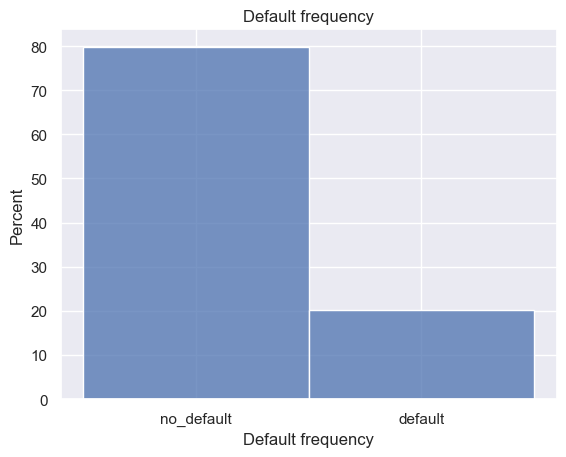

In [4]:
sns.set_theme()
sns.histplot(data=data, x="default_f", stat="percent") 
plt.title('Default frequency')
plt.xlabel('Default frequency') 
plt.show()

In [5]:
y=data['default']
X=data.drop(columns='default')

## Question 2. Train-test split 
Are the sets balanced in terms of the share of defaults?

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

All sets are balanced:

In [7]:
print("--- Total ---")
print(y.value_counts(normalize=True))
print("--- Train ---")
print(y_train.value_counts(normalize=True))
print("--- Test ---")
print(y_test.value_counts(normalize=True))

--- Total ---
default
0    0.797857
1    0.202143
Name: proportion, dtype: float64
--- Train ---
default
0    0.799958
1    0.200042
Name: proportion, dtype: float64
--- Test ---
default
0    0.791553
1    0.208447
Name: proportion, dtype: float64


## Domain knowledge selection for the features
There are so many variables !

We are going to compare several models : 
- Logit with a selection of variables **M1**
- Logit with a selection of variables **M2**
- Regularized logit on **M2** variables

Firm related variables

In [8]:
firm = ["age", "age2", "new", "ind2_cat", "m_region_loc", "urban_m"]

Human capital related variables

In [9]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

Financial variables

In [10]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]

Growth variables

In [11]:
d1 = [ 
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

In [12]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "age",
    "foreign_management",
    "ind2_cat",
]
M2 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1 + hr
len(M2)

36

#### Selection of the relevant variables

In [13]:
# M1
X_train_M1=X_train[M1]
X_test_M1 =X_test[M1]

In [14]:
# M2
X_train_M2=X_train[M2]
X_test_M2 =X_test[M2]

## Question 3: Model with selected variables **M1**

- Build a logit model with the selected variables **M1**. 
- Fit the model using cross-validation using the `pipeline` function from `sklearn`.
- What is the accuracy of the model on the training set? What is the accuracy of the model on the test set?

In [15]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

#### No regularisation needed so setting the paremeter to very high value

In [16]:
C_value_logit = [1e20]

#### Where we put the results of the different models, for comparison purposes:

In [17]:
test_accuracy={}
test_auc_roc={}

### Model 1: Logit
#### Set up Logit model object

In [18]:
logistic = LogisticRegressionCV(
    Cs=C_value_logit,   #  # Cs: inverse of regularization strength.
    cv=k,               # 5-fold cross-validation
    refit=True,         # Refit the best estimator with the entire dataset
    solver="newton-cg", # Optimization algorithm
    tol=1e-7,           # Tolerance for stopping criteria
    random_state=42,    # Random seed
)

#### Creating the pipeline

In [19]:
pipeline_logit = Pipeline([
    ('standardize', StandardScaler()),
    ('log_reg', logistic)
                          ])
pipeline_logit

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

#### On M1 features set

In [20]:
pipeline_logit.fit(X_train_M1, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('log_reg',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

In [21]:
# Predictions on the test set
y_test_hat = pipeline_logit.predict(X_test_M1)
y_test_hat_probs = pipeline_logit.predict_proba(X_test_M1)[:,1]

# Metrics
test_accuracy['logit_m1'] = accuracy_score(y_test, y_test_hat)*100
test_auc_roc['logit_m1'] = roc_auc_score(y_test, y_test_hat_probs)*100

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
print('Testing AUC: %.4f %%' % test_auc_roc['logit_m1'])
print('Testing accuracy: %.4f %%' % test_accuracy['logit_m1']) 


Confusion matrix:
 [[3615  152]
 [ 786  206]]
Testing AUC: 76.5941 %
Testing accuracy: 80.2900 %


## Question 4: Implement a similar approach for the  **M2** set. 

We need to deal with all the features: depending on their type, the pre-processing will be different

##### Categorical features

In [22]:
from sklearn.compose import make_column_selector as selector 

categorical_columns_selector = selector(dtype_include=object)  # Selects all columns of type object
categorical_features = categorical_columns_selector(X_train_M2) # Apply the selector to the training set
categorical_features

['m_region_loc']

In [23]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
categorical_transformer

Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

##### Numeric features

In [24]:
numeric_features = [col for col in X_train_M2.columns if col not in categorical_features] # Select the columns that are not categorical
len(numeric_features)

35

In [25]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [26]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['sales_mil_log', 'sales_mil_log_sq', 'age',
                                  'age2', 'new', 'ind2_cat', 'urban_m',
                                  'total_assets_bs', 'fixed_assets_bs',
                                  'liq_assets_bs', 'curr_assets_bs',
                                  'share_eq_bs', 'subscribed_cap_bs',
                                  'intang_assets_bs', 'extra_exp_pl',
                                  'extra_inc_pl', 'extra_profit_loss_pl',
                                  'inc_bef_tax_pl', 'inventories_pl',
                                  'material_exp_pl', 'profit_loss_year_pl',
                                  'personnel_exp_pl', 'd1_sales_mil_log_mod',
                                  'd1_sales_mil_log_mod_sq',
                                  'flag_low_d1_sales_mil_log',
                                  'flag_high_d1_sales_mil_log', 'female',
                                  'ceo_age', 'flag_high_ceo_age',
                                  'flag_low_ceo_age', ...]),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['m_region_loc'])])

##### The pipeline:

In [27]:
#Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
pipeline_logit = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", logistic)]
)
pipeline_logit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sales_mil_log',
                                                   'sales_mil_log_sq', 'age',
                                                   'age2', 'new', 'ind2_cat',
                                                   'urban_m', 'total_assets_bs',
                                                   'fixed_assets_bs',
                                                   'liq_assets_bs',
                                                   'curr_assets_bs',
                                                   'share_eq_bs',
                                                   'subscribed_cap_bs',
                                                   'intang_assets_bs',
                                                   'extra_exp_pl',
                                                   'extra_inc_pl',
                                                   'extr...
                                                   'flag_low_d1_sales_mil_log',
                                                   'flag_high_d1_sales_mil_log',
                                                   'female', 'ceo_age',
                                                   'flag_high_ceo_age',
                                                   'flag_low_ceo_age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['m_region_loc'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

In [28]:
logistic = LogisticRegressionCV(
    Cs=C_value_logit,   #  # Cs: inverse of regularization strength.
    cv=k,               # 5-fold cross-validation
    refit=True,         # Refit the best estimator with the entire dataset
    solver="newton-cg", # Optimization algorithm
    tol=1e-7,           # Tolerance for stopping criteria
    random_state=42,    # Random seed
)

In [29]:
pipeline_logit.fit(X_train_M2, y_train)

y_train_hat = pipeline_logit.predict(X_train)
y_train_proba_hat = pipeline_logit.predict_proba(X_train)

# Predictions on the test set
y_test_hat = pipeline_logit.predict(X_test_M2)
y_test_hat_probs = pipeline_logit.predict_proba(X_test_M2)[:,1]


In [30]:
# Metrics
test_accuracy['logit_m2'] = accuracy_score(y_test, y_test_hat)*100
test_auc_roc['logit_m2'] = roc_auc_score(y_test, y_test_hat_probs)*100


## Question 5: plot the ROC curve for the model with selected variables **M2**
- What is the ROC curve for the model with selected variables **M2**?

In [33]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_hat_probs)
roc_auc = metrics.auc(fpr, tpr)
threshold

array([       inf, 0.95264341, 0.8779279 , ..., 0.01644901, 0.01611382,
       0.00247097])

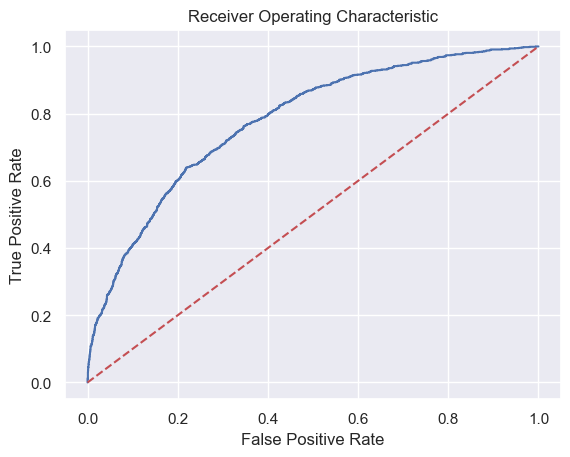

In [34]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Question 6: Comparing performance for the 2 logit models using the `auc` and `accuracy` metrics 

Which model is better ?

In [31]:
test_auc_roc

{'logit_m1': 76.59411742038243, 'logit_m2': 77.87974087363095}

In [32]:
test_accuracy

{'logit_m1': 80.28997688590039, 'logit_m2': 80.96238705610422}

#### Deciding on the model

`logit_m2` seems to perform marginaly better on the test set. 

## Question 7: Re-estimate the model on the full dataset

In [35]:
#Append classifier to preprocessing pipeline. Now we have a full prediction pipeline.
pipeline_logit = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", logistic)]
)
pipeline_logit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sales_mil_log',
                                                   'sales_mil_log_sq', 'age',
                                                   'age2', 'new', 'ind2_cat',
                                                   'urban_m', 'total_assets_bs',
                                                   'fixed_assets_bs',
                                                   'liq_assets_bs',
                                                   'curr_assets_bs',
                                                   'share_eq_bs',
                                                   'subscribed_cap_bs',
                                                   'intang_assets_bs',
                                                   'extra_exp_pl',
                                                   'extra_inc_pl',
                                                   'extr...
                                                   'flag_low_d1_sales_mil_log',
                                                   'flag_high_d1_sales_mil_log',
                                                   'female', 'ceo_age',
                                                   'flag_high_ceo_age',
                                                   'flag_low_ceo_age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['m_region_loc'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

In [36]:
X_M2 = X[M2]

In [37]:
logLasso=pipeline_logit.fit(X_M2, y)
logLasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['sales_mil_log',
                                                   'sales_mil_log_sq', 'age',
                                                   'age2', 'new', 'ind2_cat',
                                                   'urban_m', 'total_assets_bs',
                                                   'fixed_assets_bs',
                                                   'liq_assets_bs',
                                                   'curr_assets_bs',
                                                   'share_eq_bs',
                                                   'subscribed_cap_bs',
                                                   'intang_assets_bs',
                                                   'extra_exp_pl',
                                                   'extra_inc_pl',
                                                   'extr...
                                                   'flag_low_d1_sales_mil_log',
                                                   'flag_high_d1_sales_mil_log',
                                                   'female', 'ceo_age',
                                                   'flag_high_ceo_age',
                                                   'flag_low_ceo_age', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['m_region_loc'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=[1e+20],
                                      cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                      random_state=42, solver='newton-cg',
                                      tol=1e-07))])

### Using the model 

In [38]:
#y_new_hat = logLasso.predict(X_new)